<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Logistic Regression for MNIST Digit Classification**  

## **How It Works:**  
Logistic regression is used for classification tasks by predicting probabilities for each class. It learns patterns in the input data and assigns the most likely label to each digit.  
$$$$

For **multi-class classification**, there are two common approaches:  
1. **One-vs-All (OvA)** → Trains separate classifiers for each class.  
2. **Softmax Regression** → Uses a single model to classify all classes at once.  

$$$$
### **Why Softmax?**  
Softmax regression is more efficient because it directly assigns probabilities to multiple classes in a single step, making it better suited for problems like MNIST digit classification.  


#### Keywords for Dimensions:
m => no. of samples

n => no. of features

k => no. of unique classes

# Importing library and files

Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=4fa4dcec-0d64-4e06-818e-7ea2bb15c6c2
To: /content/dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 73.3MB/s] 


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
no. of data sample : 60000
Training data shape: (48000, 784)
Test data shape: (12000, 784)


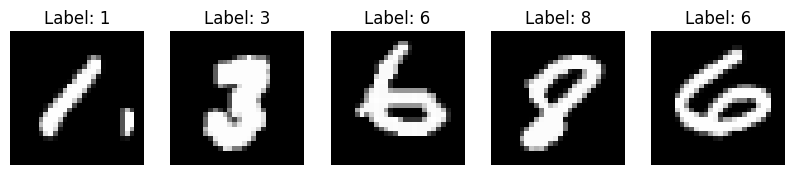

In [1]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import train_test_split

# file import from derive
file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
url = f"https://drive.google.com/uc?id={file_id}"

# downloading file
output = "dataset.csv"
gdown.download(url, output, quiet=False)

# dataframe formation
df = pd.read_csv(output, header=None)

print(df.head())

# making y = label(1st column) and x = row (other column).
y = df.iloc[:, 0].values  # Labels
X = df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X = X / 255.0

# dataset size
total_samples = X.shape[0]
print(f"no. of data sample : {total_samples}")

# logic for spliting
train_ratio = 0.8  # train = 80% and test = 20%
train_size = int(total_samples * train_ratio)
test_size = total_samples - train_size

# spliting by sklearn and also i make sure that split is balance by using 'startify = y'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42
)

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()


## One Hot Encoding


> This function converts class labels into a one-hot encoded matrix. It first creates a matrix of zeros with m rows and num_classes columns, then it places a 1 in the column corresponding to each class label.



In [2]:
# One-hot encode function dim(m,k)

def one_hot_encode(Y, num_classes):
    m = Y.shape[0]
    one_hot_Y = np.zeros((m, num_classes))
    one_hot_Y[np.arange(m), Y] = 1
    return one_hot_Y

## Adding baise term:


> for example:
dim(X) = (m,n) but dim(X_trian_bais) = (m,n+1)


In [3]:
# adding bais in matrix
def add_bias_term(X):
    m = X.shape[0]

    # adding column of 1's.
    X_bias = np.c_[np.ones((m, 1)), X]

    return X_bias


## Theta initialization:
 Dim (θ) = (n+1,k)

In [4]:
# initializing theta with dim => (n+1,k) with random small values

def initialize_weights(n_features, n_classes):
    np.random.seed(42)  # For reproducibility

    Theta = np.random.randn(n_features + 1, n_classes) * 0.01
    return Theta

## **Softmax Function**  
this function is use to classify multiple class at a time .

(i have in place of sigmoid function which is used for binary classification.)

### **Formula:**  
$$
\sigma(Z_i) = \frac{e^{Z_i}}{\sum_{j} e^{Z_j}}
$$  
where:  
- $Z$ is the input (logits).  
- $e^{Z_i}$ represents the exponentiation of each element.  
$$$$
- this is normalize too. and σ(Zi)  is prediction probability.

### For Numerical Stability:
To avoid large exponent values, we subtract the maximum value in $Z$ before putting its value in exponential.  
$$
\text{e}^{zi} = e^{Z - \max(Z)}
$$  



In [5]:
# softmax function

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

In [6]:
#inititalizing theta (n+1,k)

def initialize_weights(n_features, n_classes):
    np.random.seed(42) # for same result
    Theta = np.random.randn(n_features + 1, n_classes) * 0.01
    return Theta

## Calculating prediction of training data:
dimension => (m,k)

In [7]:
def predict_probabilities(X, Theta):

    Z_theta = np.dot(X, Theta)

    P = softmax(Z_theta)  # Shape (m, k)

    return P

## **Cross-Entropy Cost Function**    

#### **Formula:**  
$$
J = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{n} Y_{ij} \log P_{ij}
$$  
where:  
- $m$ is the number of samples.  
- $Y_{ij}$ is the one-hot encoded true label.  
- $P_{ij}$ is the predicted probability for class $j$.  

#### **Numerical Stability:**  
to avoid invalid output problem , range of P = (ϵ,1-ϵ)

In [8]:
#cost function

def compute_cost(Y, P):
    m = Y.shape[0]
    epsilon = 1e-9

    P = np.clip(P, epsilon, 1 - epsilon)  # restricated range of P

    J = - (1 / m) * np.sum(np.sum(Y * np.log(P), axis=1))

    return J

## **Gradient Computation for Softmax Regression**  

### **Formula:**  
For a dataset with $m$ samples and $n$ features, the gradient is computed as:  
$$
\nabla_{\Theta} J = \frac{1}{m} X^T (P - Y)
$$  
where:  
- $X$ is the input data of shape $(m, n)$.  
- $Y$ is the one-hot encoded true labels of shape $(m, k)$.  
- $P$ is the predicted probability matrix of shape $(m, k)$.  
- $\Theta$ represents the model parameters (weights).  

In [9]:
#compute gradient

def compute_gradient(X, Y, P):
    m = X.shape[0]  # Number of samples

    dTheta = (1 / m) * np.dot(X.T, (P - Y))  # Shape (n+1, k)

    return dTheta


## **Gradient Descent for Softmax Regression**  

#### **Update Rule:**  
Gradient descent updates the parameters **Θ** using the following formula:  
$$
\Theta := \Theta - \alpha \nabla_{\Theta} J
$$  
where:  
- $\alpha$ is the **learning rate**.  
- $\nabla_{\Theta} J$ is the **gradient of the cost function**.  
- $\Theta$ represents the model parameters (weights).   


In [10]:
from tqdm import tqdm

def gradient_descent(X, Y, theta, alpha, epochs):
    cost_history = []
    m = X.shape[0]

    for i in tqdm(range(epochs), desc="training Progress", ncols=100, unit="epoch"):
        P = predict_probabilities(X, theta)  # Compute predictions
        cost = compute_cost(Y, P)  # Compute cost
        cost_history.append(cost)

        dTheta = compute_gradient(X, Y, P)  # Compute gradient

        theta -= alpha * dTheta  # Update weights

        if i % 100 == 0:
            gradient_norm = np.linalg.norm(dTheta)
            print(f"Cost = {cost:.4f}, Gradient Norm = {gradient_norm:.4f}")

    return theta, cost_history


training Progress:   0%|                                        | 1/1200 [00:00<05:16,  3.79epoch/s]

Cost = 2.3239, Gradient Norm = 1.0463


training Progress:   8%|███▏                                  | 101/1200 [00:26<04:17,  4.27epoch/s]

Cost = 0.6101, Gradient Norm = 0.1466


training Progress:  17%|██████▎                               | 201/1200 [00:54<03:54,  4.27epoch/s]

Cost = 0.4898, Gradient Norm = 0.0829


training Progress:  25%|█████████▌                            | 301/1200 [01:20<03:35,  4.18epoch/s]

Cost = 0.4405, Gradient Norm = 0.0598


training Progress:  33%|████████████▋                         | 401/1200 [01:47<03:12,  4.16epoch/s]

Cost = 0.4121, Gradient Norm = 0.0476


training Progress:  42%|███████████████▊                      | 501/1200 [02:13<02:44,  4.25epoch/s]

Cost = 0.3930, Gradient Norm = 0.0400


training Progress:  50%|███████████████████                   | 601/1200 [02:39<02:21,  4.24epoch/s]

Cost = 0.3791, Gradient Norm = 0.0348


training Progress:  58%|██████████████████████▏               | 701/1200 [03:06<01:56,  4.27epoch/s]

Cost = 0.3684, Gradient Norm = 0.0309


training Progress:  67%|█████████████████████████▎            | 801/1200 [03:32<01:33,  4.27epoch/s]

Cost = 0.3597, Gradient Norm = 0.0280


training Progress:  75%|████████████████████████████▌         | 901/1200 [03:59<01:09,  4.29epoch/s]

Cost = 0.3525, Gradient Norm = 0.0256


training Progress:  83%|██████████████████████████████▊      | 1001/1200 [04:25<00:47,  4.20epoch/s]

Cost = 0.3464, Gradient Norm = 0.0237


training Progress:  92%|█████████████████████████████████▉   | 1101/1200 [04:52<00:23,  4.22epoch/s]

Cost = 0.3412, Gradient Norm = 0.0221


training Progress: 100%|█████████████████████████████████████| 1200/1200 [05:18<00:00,  3.77epoch/s]


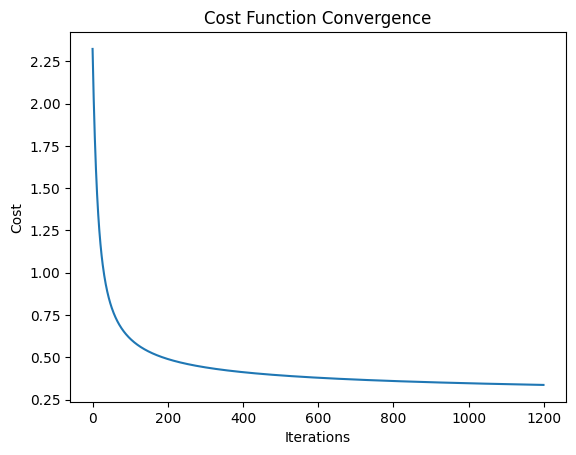

In [11]:
alpha = 0.1  # learning rate
epochs = 1200  # number of iterations

num_classes = 10
n_features = X_train.shape[1]

# initialize weights
theta = initialize_weights(n_features, num_classes)

#baising added
X_train_bias = add_bias_term(X_train)

# One-hot encode Y_train
Y_train_one_hot = one_hot_encode(y_train, num_classes)

# model training
Theta_opt, cost_history = gradient_descent(X_train_bias, Y_train_one_hot, theta, alpha, epochs)

# Plot cost history
plt.plot(cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost Function Convergence")
plt.show()


# Evaluation part

## prediciton on test dataset

In [12]:
def predict(X, Theta):
    P = predict_probabilities(X, Theta)
    predictions = np.argmax(P, axis=1)
    return predictions, P

#--------------------------------------------------------
X_test_bias = add_bias_term(X_test)
y_pred, P_test = predict(X_test_bias, Theta_opt)

## Confusion matrix

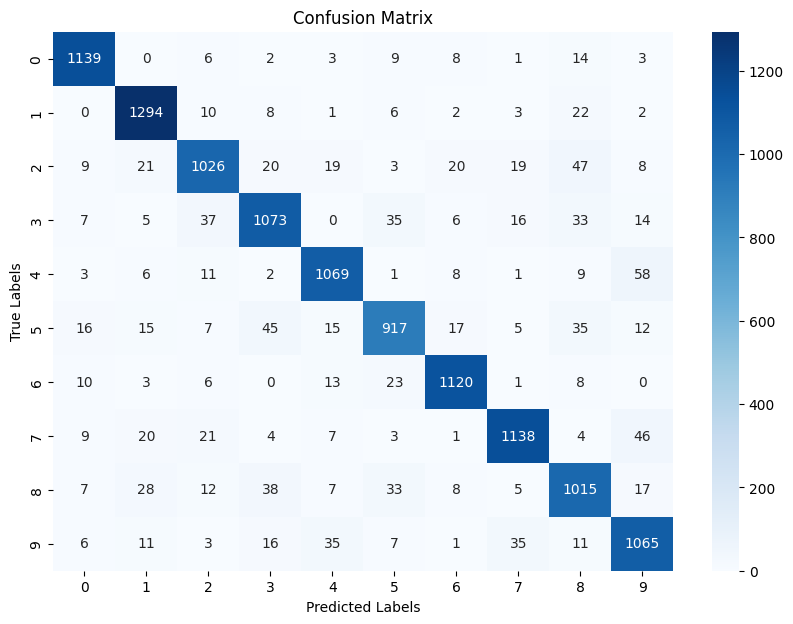

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## precision, recall, f1_score, support

In [14]:

num_classes = conf_matrix.shape[0]

# initializing precision, recall, f1_score
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

# Calculting matrix of above things
for i in range(num_classes):
    TP = conf_matrix[i, i]  # True Positives
    FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives

    precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0.0

# Printing
print("\nClassification matrics :")
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-score={f1_score[i]:.4f}")



Classification matrics :
Class 0: Precision=0.9444, Recall=0.9612, F1-score=0.9527
Class 1: Precision=0.9223, Recall=0.9599, F1-score=0.9407
Class 2: Precision=0.9008, Recall=0.8607, F1-score=0.8803
Class 3: Precision=0.8882, Recall=0.8752, F1-score=0.8817
Class 4: Precision=0.9145, Recall=0.9152, F1-score=0.9148
Class 5: Precision=0.8843, Recall=0.8459, F1-score=0.8647
Class 6: Precision=0.9404, Recall=0.9459, F1-score=0.9432
Class 7: Precision=0.9297, Recall=0.9082, F1-score=0.9189
Class 8: Precision=0.8472, Recall=0.8675, F1-score=0.8573
Class 9: Precision=0.8694, Recall=0.8950, F1-score=0.8820


## Overall Accuracy

In [15]:
# overall accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"\nAccuracy: {accuracy:.4f}")



Accuracy: 0.9047


## ROC curve

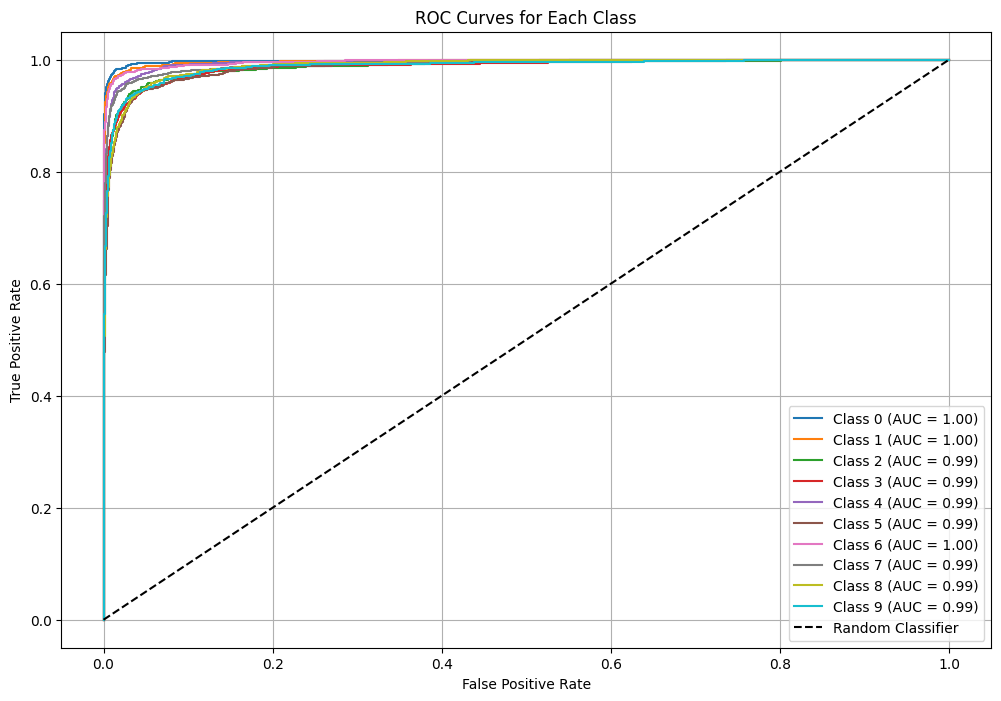

In [16]:

plt.figure(figsize=(12, 8))
for i in range(10):  # 10 classes
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), P_test[:, i])  # One-vs-all ROC curve
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.grid()
plt.show()


## Accuracy per class

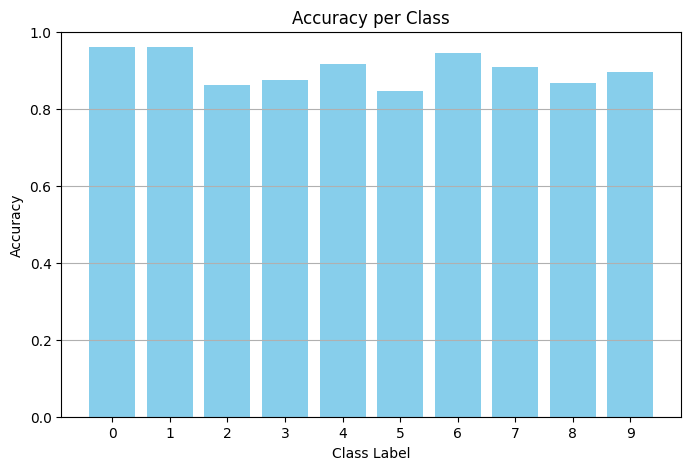

In [17]:

class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(8, 5))
plt.bar(range(10), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

## Some Predicition example

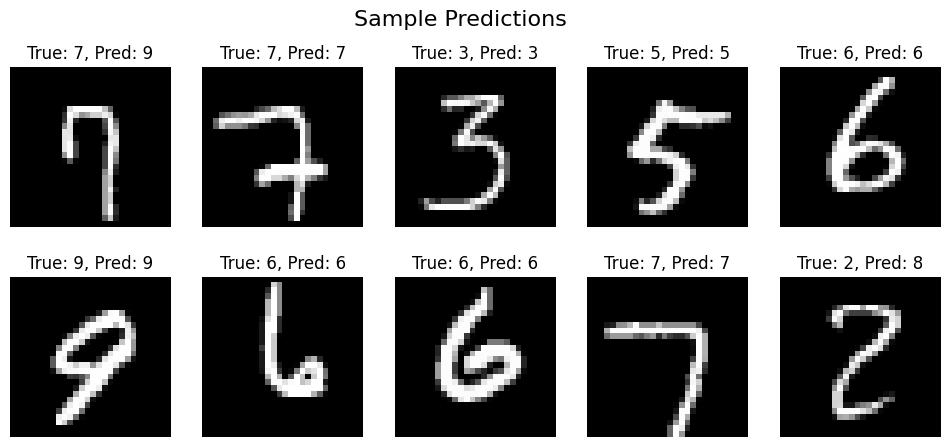

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()